In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.hub
import random

import torchvision
import torchvision.utils
from torchvision.models import detection
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.ssd import SSD

import dataset as data
import utils as utils
import pickle
import attackMethods as am

print(torch.__version__)
print(torch.cuda_version)
print(torchvision.__version__)

1.10.0+cu113
11.3
0.11.1+cu113


In [2]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

dataset = data.AdversarialDataset((480,480)) # todo: use resize to pull picture in batch

loss = am.lossObjectness

batch_size = 1

train_loader  = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)

#device = torch.device("cpu")
device = torch.device("cuda:0")
#'cuda:0' or 'cpu'

In [3]:
#train on pictures from dset (pictures with persons in personIndex list)

model.eval()
model = model.float().to(device)

for param in model.parameters():
    param.requires_grad = False

patch = am.generatePatch()
#patch = am.patchFromImage("meme.jpg")
patch = patch.to(device)
patch.requires_grad = True

TVCoeff = pow(10,-11)
GradRate = 0.03

augmentations = torchvision.transforms.Compose([
        torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.2, saturation=0.2, hue=0.05),
        torchvision.transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 0.3)),
        torchvision.transforms.RandomPerspective(distortion_scale=0.2, p=1.0),
        torchvision.transforms.RandomRotation(degrees=(-30, 30)),])

#personIndex = []

epoches = 1

class StopExecution(Exception):
    def _render_traceback_(self):
        pass

for epoch in range(epoches):
    imageCounter = 0
    for image, label in train_loader:
        imageCounter += batch_size
        for k in range(1):
            cv2.imshow("patch", cv2.cvtColor(cv2.resize(data.TenToIm(patch.clone().detach().to(torch.device("cpu"))/255), (300,300)), cv2.COLOR_RGB2BGR))

            attackedImage = []

            torch.cuda.empty_cache()

            for im in image:
                attackedImage.append(data.ImToTen(im).to(device))

            #for attackedIm in attackedImage:
            #    attackedIm.requires_grad = True

            with torch.no_grad():
                clearPredict = model(attackedImage)

            augmented_patch = augmentations(patch)

            for i in range(len(attackedImage)):
                for l in label[i]:
                    attackedImage[i] = am.setPatch(attackedImage[i], augmented_patch, l, 0.2, device) 

            predict = model(attackedImage)

            costs = []

            for i in range(len(clearPredict)):
                cost = loss(clearPredict[i], predict[i]) + TVCoeff * am.TV(patch, device)
                if cost < 0.1:
                    continue
                try:
                    grad = torch.autograd.grad(cost, patch, retain_graph=False, create_graph=False,  allow_unused=True)[0]
                    if grad != None:
                        patch = patch - GradRate*grad.sign()
                except:
                    pass
                costs.append(cost.detach().cpu())
            

            print("ep:", epoch,"epoch_progress:", imageCounter/len(dataset), "loss:", np.mean(np.asarray(costs)))

            for attackedIm in attackedImage:
                attackedIm.detach()

            key = cv2.waitKey(1)
            if key & 0xFF == ord('q'):
                cv2.destroyAllWindows() 
                utils.SavePatch(patch.cpu(), "patch - meme")
                raise StopExecution


c:\Users\Степан\Desktop\учеба\Диплом\FromUbuntu\diplomfile\dataset.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(image).permute(2, 0, 1).float() / 255)
C:\Users\Степан\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


ep: 0 epoch_progress: 8.45401438873249e-06 loss: 1.1140583
ep: 0 epoch_progress: 1.690802877746498e-05 loss: 1.1297797
ep: 0 epoch_progress: 2.536204316619747e-05 loss: 1.1039487
ep: 0 epoch_progress: 3.381605755492996e-05 loss: 1.102827
ep: 0 epoch_progress: 4.227007194366245e-05 loss: 1.1237875
ep: 0 epoch_progress: 5.072408633239494e-05 loss: 2.2375205
ep: 0 epoch_progress: 5.917810072112743e-05 loss: 1.1367221


C:\Users\Степан\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Степан\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ep: 0 epoch_progress: 6.763211510985992e-05 loss: nan
ep: 0 epoch_progress: 7.608612949859241e-05 loss: 1.1163669
ep: 0 epoch_progress: 8.45401438873249e-05 loss: 1.1580895
ep: 0 epoch_progress: 9.299415827605739e-05 loss: nan
ep: 0 epoch_progress: 0.00010144817266478988 loss: nan
ep: 0 epoch_progress: 0.00010990218705352236 loss: nan
ep: 0 epoch_progress: 0.00011835620144225486 loss: 3.9933395
ep: 0 epoch_progress: 0.00012681021583098735 loss: nan
ep: 0 epoch_progress: 0.00013526423021971985 loss: nan
ep: 0 epoch_progress: 0.00014371824460845232 loss: 1.3862958
ep: 0 epoch_progress: 0.00015217225899718482 loss: nan
ep: 0 epoch_progress: 0.00016062627338591731 loss: 1.156537
ep: 0 epoch_progress: 0.0001690802877746498 loss: nan
ep: 0 epoch_progress: 0.00017753430216338229 loss: 1.120999
ep: 0 epoch_progress: 0.00018598831655211478 loss: nan
ep: 0 epoch_progress: 0.00019444233094084726 loss: nan
ep: 0 epoch_progress: 0.00020289634532957975 loss: 1.1033578
ep: 0 epoch_progress: 0.0002113

RuntimeError: CUDA out of memory. Tried to allocate 40.00 MiB (GPU 0; 2.00 GiB total capacity; 909.01 MiB already allocated; 30.50 MiB free; 974.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

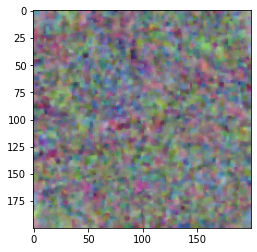

In [4]:
torch.cuda.empty_cache()
cv2.destroyAllWindows() 
utils.ShowPatch(patch.cpu())

In [8]:
#image, label = dataset[personIndex[7]]
#network parameters requar. grad

In [9]:
patch = utils.LoadPatch("patch - meme")

In [8]:
utils.SavePatch(patch.cpu(), "patch - meme")

In [24]:
with open('0_4784.pickle', 'wb') as f:
    pickle.dump(personIndex, f)

In [4]:
with open('0_4784.pickle', 'rb') as f:
    personIndex = pickle.load(f)

In [9]:
image, label = dataset[5]
patch = utils.TrainOneImage(model, loss, image, label, epoches=100000)

loss: tensor(2.7238, grad_fn=<AddBackward0>) iter: 0
loss: tensor(2.7176, grad_fn=<AddBackward0>) iter: 1
loss: tensor(2.6642, grad_fn=<AddBackward0>) iter: 2
loss: tensor(1.5190, grad_fn=<AddBackward0>) iter: 3
loss: tensor(2.6184, grad_fn=<AddBackward0>) iter: 4
loss: tensor(1.3814, grad_fn=<AddBackward0>) iter: 5
loss: tensor(1.5894, grad_fn=<AddBackward0>) iter: 6
loss: tensor(1.1213, grad_fn=<AddBackward0>) iter: 7
loss: tensor(1.4041, grad_fn=<AddBackward0>) iter: 8
loss: tensor(2.6382, grad_fn=<AddBackward0>) iter: 9
loss: tensor(1.1889, grad_fn=<AddBackward0>) iter: 10
loss: tensor(1.6250, grad_fn=<AddBackward0>) iter: 11
loss: tensor(2.7796, grad_fn=<AddBackward0>) iter: 12
loss: tensor(2.8311, grad_fn=<AddBackward0>) iter: 13
loss: tensor(1.1218, grad_fn=<AddBackward0>) iter: 14
loss: tensor(1.9940, grad_fn=<AddBackward0>) iter: 15
loss: tensor(1.6563, grad_fn=<AddBackward0>) iter: 16
loss: tensor(1.1073, grad_fn=<AddBackward0>) iter: 17
loss: tensor(1.3729, grad_fn=<AddBackw

StopExecution: 

In [23]:
for i in range(20):
    image, label = dataset[personIndex[i]]
    utils.CheckPatch(patch, image, label, model, device, loss)

Clear loss: tensor(1.1095, grad_fn=<MulBackward0>) Attacked loss: tensor(1.1095, grad_fn=<MulBackward0>)
Clear loss: tensor(1.2138, grad_fn=<MulBackward0>) Attacked loss: tensor(1.1075, grad_fn=<MulBackward0>)
Clear loss: tensor(1.1265, grad_fn=<MulBackward0>) Attacked loss: tensor(1.1043, grad_fn=<MulBackward0>)
Clear loss: tensor(1.1616, grad_fn=<MulBackward0>) Attacked loss: tensor(1.2186, grad_fn=<MulBackward0>)
Clear loss: tensor(1.1064, grad_fn=<MulBackward0>) Attacked loss: tensor(1.1702, grad_fn=<MulBackward0>)
Clear loss: tensor(1.8352, grad_fn=<MulBackward0>) Attacked loss: tensor(1.1531, grad_fn=<MulBackward0>)
Clear loss: tensor(1.4608, grad_fn=<MulBackward0>) Attacked loss: tensor(1.1437, grad_fn=<MulBackward0>)
Clear loss: tensor(1.1680, grad_fn=<MulBackward0>) Attacked loss: tensor(1.1739, grad_fn=<MulBackward0>)
Clear loss: tensor(1.1299, grad_fn=<MulBackward0>) Attacked loss: tensor(1.1785, grad_fn=<MulBackward0>)
Clear loss: tensor(1.6535, grad_fn=<MulBackward0>) Atta